# Drosophila melanogaster muscle contractility test methodology - computational biology in data analysis

<p> Contractility tests allow to calculate Contractility index (CI) of the muscle. 
CI allows researchers to detect impacts of different factors to muscle function under different conditions (for example knock-down, mutation, overexpression of gene, drug's impact). Drosophila melanogaster larva is a good model organism for such research because of cheap husbandry, no ethical dylemats, small genom.

<p> The methodology seems to be simple and usefull, but has some disadvantages, such as: </p>

- very difficult dissecion procedure (losing of the material, muscle damage, time consuming, requiered special researcher's skills)
- some part of body wall muscles segments are damaged and there is different number of muscles from each individual
- size of relaxed fiber and size of contracted fiber always come from different individuals, which differ among each other in relaxed muscle length (sometimes one individuals contracted muscle is longer that relaxed muscle form another individual and contractility index can be negative number)
- muscle length data come from different individuals, but single measurements from one individual are repeated which can result in pseudoreplication
- data analysis can produce positive or negative results depending of method choosen by researcher. Unproper methodology prompt to loosing important information about biological changes in muscle function
- neccesity of some measurement exclusion if number of measurement differ among relaxed/contracted data (as a result of material lost during dissection procedure)


<p> The goal of this study is to develop data analysis method based on computational biology, overcoming data analysis methodology problems and allowing to detect biological changes, reducing false positive or false negative results of the experiments. All steps that normally had to be choosen "by hand" by experimentator are made randomly by computer, to obtain results independent of human factor.  Methodology of data analysis have not been found in literature so far. </p>

### Methods
Program allows to perform simulation in the number that calculation power of computer allows*. The same data from contractility test can produce propably more than billions of results (it's impossible to calculate exact number using available tools), depending of choosen method. Program was written to perform computational simulation of data analysis in different methods i all combinations and collect data from each simulation. User of program can choose between following parameters:
- excluding values from bigger groups to recieve the same number of values in each group (relaxed/contracted) or replace missing values with mean/median
- collecting means of values recieved from each simulation or collecting all values from each simulation to one dataset (without mean)
- excluding results with negative Contractility index from each simulation before mean calculating
- sorting contracted/relaxed fiber sizes from the shortest to the longests and calculating CI repsectively, or CI in pairs chosed randomly
- calculating Contractility index from mean/median of all fibers sizes in dataset in this case it's impossible to calculate P=value or standard error from the data)

Using combinations of all method variants describe above is possible to performed around 20 different results. 

### Data used in program testing
Data is artificial, based on exerimental data.

### Discussion

Depending of data analysis methodology results can differ among each other. 
### Perspectives 
Further using of biologically positive data will allow to reject methods which will not show the point of the experiment and choose the best ones and avoid false posotives or false negatives. 

#### csv file requierements (with data) :
- sample name is in column "line" (the same name of line in csv will appear on the plot)
- contracted lenghtgs are in column "edta" as "no" and relaxed muscles as "yes"
- muscle lengths are in column "length [um]"

### Python 3.7. Code:

In [7]:
"""csv file requierements:
- sample name is in column "line" (the same name of line in csv will appear on the plot)
- contracted lenghtgs are in column "edta" as "no" and relaxed muscles as "yes"
- muscle lengths are in column "length [um]"

"""    

# import packages
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import random
from scipy.stats import ttest_ind
random.seed(0)
snapshots = {}


In [8]:
def process_data(relaxed, contracted, sort=False, exclude=True):
    
    """ Function processes data before matching in pairs to calculate Contractility index
    
    Arguments:
    exclude: True  - if number of relaxed and contracted group differ function excludes values from bigger group, 
    "Mean" replaces missed values with mean. 
    "Median" replaces missed values with median
    
    sort: False - in default function shuffle contracted list od data. If sort=True both lists are sorted before merging to recieve pairs according size"""
    
    len_r = len(relaxed)
    len_c = len(contracted)
    if len_r == len_c:
        pass
    else:
        if exclude == True:
            if len_r > len_c:
                relaxed = random.sample(population=relaxed, k=len_c)
            else:
                contracted = random.sample(population=contracted, k=len_r)
            
        elif exclude == "mean":
            if len_r > len_c:
                sub = len_r - len_c
                contracted = contracted + sub*[np.mean(contracted)]
            else:
                sub = len_c - len_r
                relaxed = relaxed + sub*[np.mean(relaxed)]
             
        elif exclude == "median":
            if len_r > len_c:
                sub = len_r - len_c
                contracted = contracted + sub*[np.median(contracted)]
            else:
                sub = len_c - len_r
                relaxed = relaxed + sub*[np.median(relaxed)]
        else:
            raise Exception(f"Unknown exclude: {exclude}")

    if sort == False:
        random.shuffle(contracted)
    else:
        relaxed = sorted(relaxed)
        contracted = sorted(contracted)
    return list(zip(relaxed, contracted))

def match_pairs(relaxed, contracted, exclude_negative_ci=True, sort=False, exclude=True):
    
    """Function matches relaxed and contracted values in pairs and for each pair calculates CI, and mean of CI from all pairs"""
    
    pairs = process_data(relaxed, contracted, sort=sort, exclude=exclude)
    if exclude_negative_ci:
        return [(e-n)/e for e, n in pairs if (e-n)>0]
    else:
        return [(e-n)/e for e, n in pairs]
    

def collect_data(relaxed, contracted, iterations, exclude_negative_ci=True, sort=False, exclude=True, collect="all"):
    """Function collect_data returns list of ci generated during iterations Parameters:
    collect - 
    - if collect=="all" ci lists from each iterations are merged into one list
    - if collect= "mean each list recieved from iteration is converted to mean of values from list
    sort - If sort=True both lists are sorted before merging to recieve pairs according size - random shuffle is eliminated. Deafault is False
      
    exclude_negative_ci - default True - excludes every negative ci
      
    exclude - default True, if number of relaxed and contracted group differ function excludes values from bigger group. 
      "Mean" replaces missed values with mean. 
      "Median" replaces missed values with median
      """
    if collect=="all":
        ci= []
        for i in range(iterations):
            ci += match_pairs(relaxed, contracted, exclude_negative_ci=exclude_negative_ci, sort=sort, exclude=exclude)
        return ci 
    elif collect=="mean":
        results = []
        for i in range(iterations*1000):
            r = match_pairs(relaxed, contracted, exclude_negative_ci=exclude_negative_ci, sort=sort, exclude=exclude)
            
            if len(r) >= min(len(relaxed), len(contracted)):
                results.append(r)
            if len(results) >= iterations:
                break

        return results

def prepare_data_to_plot(file_path, lines, iterations, exclude_negative_ci=True, sort=False, exclude=True, collect="all"): 
    
    """Function returns the same number of dataframes as the number od lines"""
    data = pd.read_csv(file_path)
    results = []
    for line in lines:
        relaxed = list(data[(data["edta"] == "yes") & (data["line"] == line)]["length [um]"])
        contracted = list(data[(data["edta"] == "no") & (data["line"] == line)]["length [um]"])
        indexes = collect_data(relaxed, contracted, iterations, exclude_negative_ci=exclude_negative_ci, sort=sort, exclude=exclude, collect=collect)
        df = pd.DataFrame(list(zip(indexes, [np.average(x) for x in indexes])), columns=["Contractility indexes", "Contractility index"])
        df["line"] = line
        df["ci_from_mean"] = (np.mean(relaxed) - np.mean(contracted)) / np.mean(relaxed)
        df["ci_from_median"] = (np.median(relaxed) - np.median(contracted)) / np.median(relaxed)
        if len(df) == 0:
            raise Exception(f"Line {line} doesn't exist!")
        results.append(df)     
    return results
        
flatui = ["crimson", "steelblue", "#9b59b6","#3498db", "#34495e", "#95a5a6", "#e74c3c", "#2ecc71"]
palette = { "mef": "crimson", "mefxCG4190": "steelblue"}


def plot(file_path, lines, iterations, exclude_negative_ci=True, sort=False, exclude=True, collect="all"):
    data = prepare_data_to_plot(file_path, lines, iterations, exclude_negative_ci=exclude_negative_ci, sort=sort, exclude=exclude, collect=collect)
    plt.figure(figsize=(8, 5))
    A = list(data[0]["Contractility indexes"])
    B = list(data[1]["Contractility indexes"])
    
    T = [stats.ttest_ind(a, b) for a, b in zip(A, B)]
    print(np.average([t.pvalue for t in T]))
    for line, colour in zip(data, flatui[0:len(data)]):
        sns.distplot(line["Contractility index"], rug=True, kde_kws={"label": line['line'][0]}, color=colour)
        plt.axvline(x=line["ci_from_mean"][0], color=colour)
        plt.axvline(x=line["ci_from_median"][0], color=colour, dashes=[10, 10])


def bar(file_path, lines, iterations, exclude_negative_ci=True, sort=False, exclude=True, collect="all", ttest=False):
    data = pd.concat(prepare_data_to_plot(file_path, lines, iterations, exclude_negative_ci=exclude_negative_ci, sort=sort, exclude=exclude, collect=collect))
    plt.figure(figsize=(5, 3))

    sns.catplot(x="line", y="Contractility index", hue="line", data=data, kind="box", palette=palette)
    if ttest==True:
        print(stats.ttest_ind(data[data["line"]==lines[0]]["Contractility index"], data[data["line"]==lines[1]]["Contractility index"]))
    return data


### Data

In [9]:
df = pd.read_csv("data/contractility-data.csv")
mef_relaxed = df[df.edta=="yes"][df.line=="mef"]["length [um]"]
mef_contracted = df[df.edta=="no"][df.line=="mef"]["length [um]"]

mefcg_relaxed = df[df.edta=="yes"][df.line=="mefxCG4190"]["length [um]"]
mefcg_contracted = df[df.edta=="no"][df.line=="mefxCG4190"]["length [um]"]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


### 1000 Simulations performed on the data using different methods
legend on the plots:
- straight vertical line - CI calculated from mean of all data (without matching to pairs)
- dotted vertical line - CI calculated from median of all data (without matching to pairs)

0.38061509067444405
0.43353957519613273


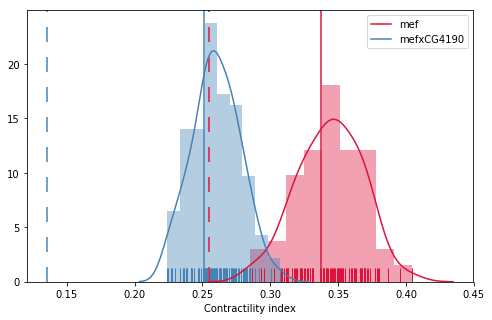

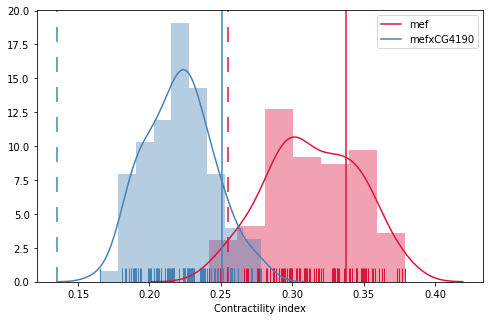

In [10]:
        
random.seed(0)       
plot("data/contractility-data.csv", ["mef", "mefxCG4190"], 100, collect="mean", exclude_negative_ci=True)
plot("data/contractility-data.csv", ["mef", "mefxCG4190"], 100, collect="mean", exclude_negative_ci=False)


0.12042162885943243
0.16485784718986068


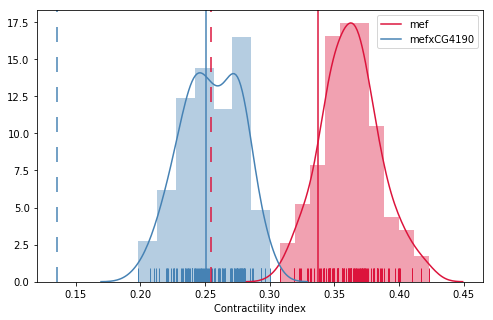

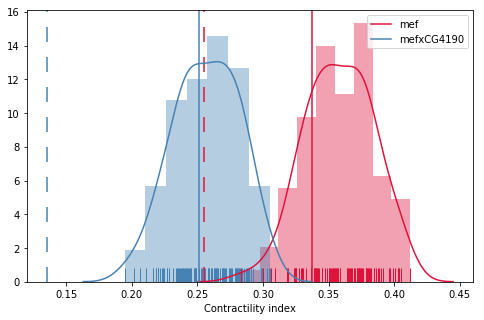

In [11]:
random.seed(0)       
plot("data/contractility-data.csv", ["mef", "mefxCG4190"], 100, collect="mean", exclude_negative_ci=True, sort=True)
plot("data/contractility-data.csv", ["mef", "mefxCG4190"], 100, collect="mean", exclude_negative_ci=False, sort=True)


/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan
nan
nan
nan


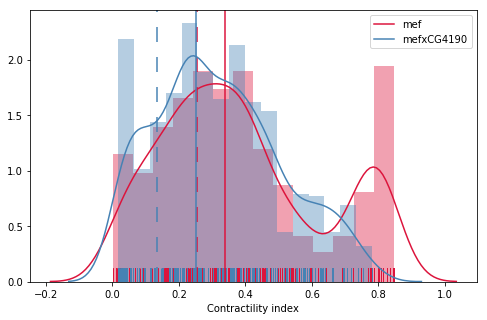

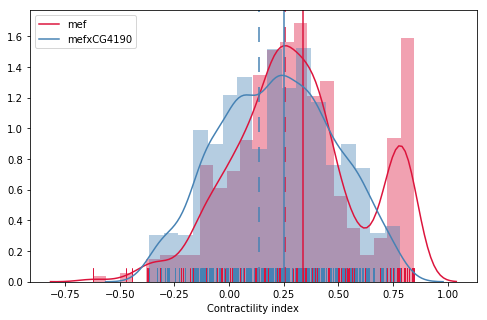

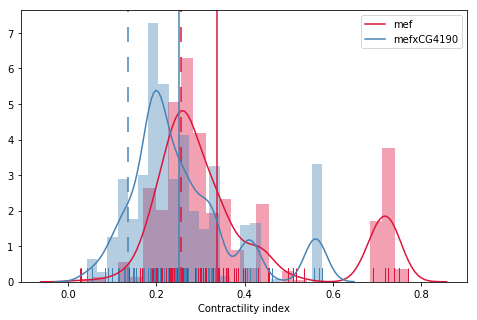

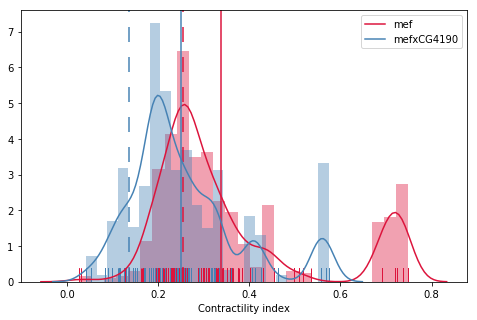

In [12]:
random.seed(0)

plot("data/contractility-data.csv", ["mef", "mefxCG4190"], 100, collect="all", exclude_negative_ci=True)
plot("data/contractility-data.csv", ["mef", "mefxCG4190"], 100, collect="all", exclude_negative_ci=False)
plot("data/contractility-data.csv", ["mef", "mefxCG4190"], 100, collect="all", exclude_negative_ci=True, sort=True)
plot("data/contractility-data.csv", ["mef", "mefxCG4190"], 100, collect="all", exclude_negative_ci=False, sort=True)

0.4113437104562612
0.222096230570502
0.6663151238040598
0.32982671989986095


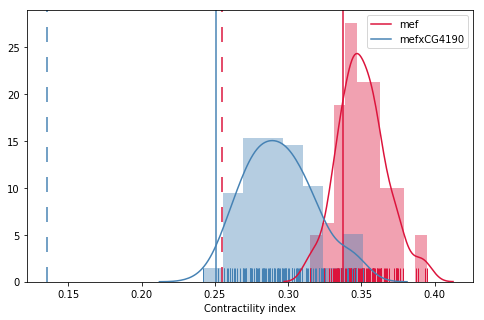

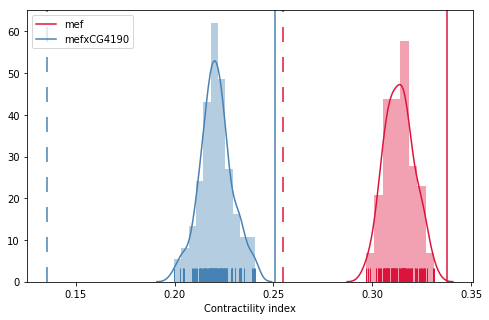

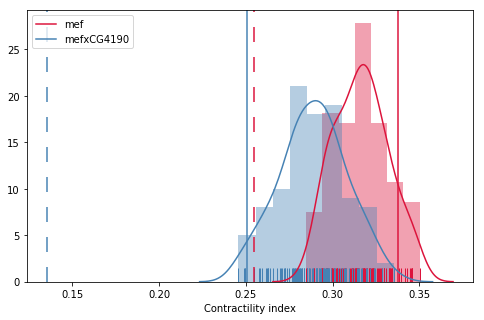

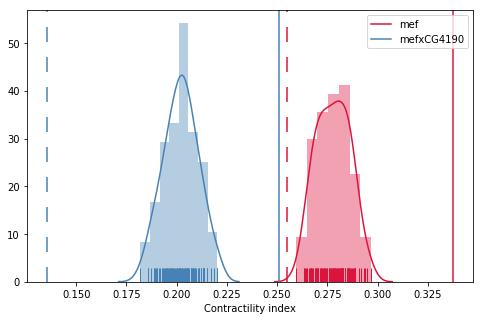

In [13]:
random.seed(0)       
plot("data/contractility-data.csv", ["mef", "mefxCG4190"], 100, collect="mean", exclude_negative_ci=True, exclude="mean")
plot("data/contractility-data.csv", ["mef", "mefxCG4190"], 100, collect="mean", exclude_negative_ci=False, exclude="mean")
plot("data/contractility-data.csv", ["mef", "mefxCG4190"], 100, collect="mean", exclude_negative_ci=True, exclude="median")
plot("data/contractility-data.csv", ["mef", "mefxCG4190"], 100, collect="mean", exclude_negative_ci=False, exclude="median")


nan
nan
nan
nan


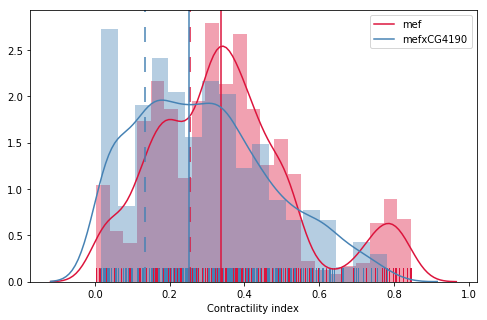

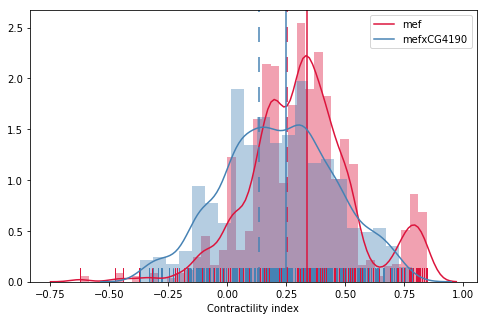

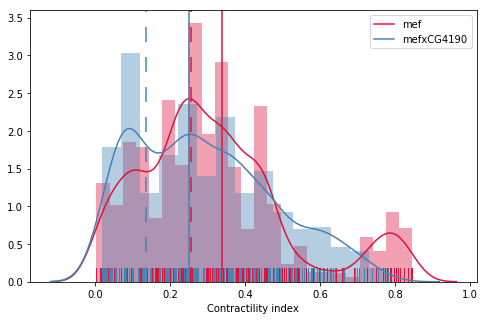

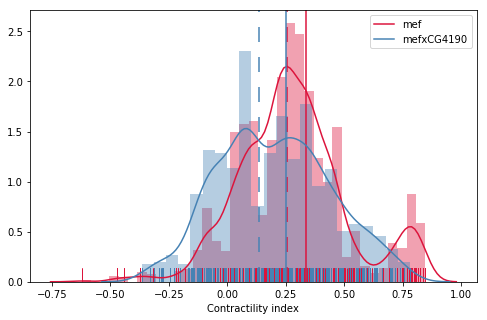

In [14]:
random.seed(0)       
plot("data/contractility-data.csv", ["mef", "mefxCG4190"], 100, collect="all", exclude_negative_ci=True, exclude="mean")
plot("data/contractility-data.csv", ["mef", "mefxCG4190"], 100, collect="all", exclude_negative_ci=False, exclude="mean")
plot("data/contractility-data.csv", ["mef", "mefxCG4190"], 100, collect="all", exclude_negative_ci=True, exclude="median")
plot("data/contractility-data.csv", ["mef", "mefxCG4190"], 100, collect="all", exclude_negative_ci=False, exclude="median")


### Tests of the program

In [15]:
# simple testdata, generated by hand with no connection to any biological data

test_data = {
    "relaxed": [130, 131, 133, 121, 125, 120, 115, 116, 110, 105, 100, 95, 90, 85, 80, 75, 70, 65, 95, 90, 85, 80],
    "contracted" : [110, 105, 100, 95, 90, 85, 80, 75, 70, 65, 95, 90, 85, 80, 75, 70, 65, 60, 55, 50, 45, 40, 35, 30, 30, 25]
}
relaxed = test_data["relaxed"]
contracted = test_data["contracted"]


# helping function

def snapshot(code):
    random.seed(0)
    name = code.__name__
    if name not in snapshots:
        result = code()
        snapshots[name] = result
        print(f"Saved snapshot for {name}:")
        print(result)
    else:
        result =code()
        if result != snapshots[name]:
            print(f"Given: {result}")
            print(f"Expected: {snapshots[name]}")
            assert False
        else:
            print(f"")
    
@snapshot
def test_process_data():
    return process_data(relaxed, contracted)

@snapshot
def test_process_data_sort():
    return process_data(relaxed, contracted, sort=True)

@snapshot
def test_process_data_mean():
    return process_data(relaxed, contracted, exclude="mean")

@snapshot
def test_match_pairs_exclude():
    return match_pairs(relaxed, contracted, exclude_negative_ci=False)
@snapshot
def test_match_pairs():
    return match_pairs(relaxed, contracted)

@snapshot
def test_collect_data_mean():
    return collect_data(relaxed, contracted, 1, collect="mean")

@snapshot
def test_collect_data_2():
    return collect_data(relaxed, contracted, 2)

Saved snapshot for test_process_data:
[(130, 30), (131, 40), (133, 95), (121, 85), (125, 95), (120, 80), (115, 60), (116, 25), (110, 65), (105, 45), (100, 35), (95, 85), (90, 100), (85, 70), (80, 65), (75, 75), (70, 90), (65, 90), (95, 80), (90, 105), (85, 50), (80, 70)]
Saved snapshot for test_process_data_sort:
[(65, 25), (70, 30), (75, 35), (80, 40), (80, 45), (85, 50), (85, 60), (90, 65), (90, 65), (95, 70), (95, 70), (100, 75), (105, 80), (110, 80), (115, 85), (116, 85), (120, 90), (121, 90), (125, 95), (130, 95), (131, 100), (133, 105)]
Saved snapshot for test_process_data_mean:
[(130, 75), (131, 110), (133, 30), (121, 55), (125, 80), (120, 85), (115, 75), (116, 95), (110, 35), (105, 45), (100, 90), (95, 100), (90, 40), (85, 95), (80, 60), (75, 90), (70, 50), (65, 65), (95, 25), (90, 70), (85, 65), (80, 70), (100.72727272727273, 105), (100.72727272727273, 80), (100.72727272727273, 30), (100.72727272727273, 85)]
Saved snapshot for test_match_pairs_exclude:
[0.7692307692307693, 0.4

### Versions of Packages used in study

- seaborn==0.9.0
- scipy==1.1.0
- pandas==0.23.4
- numpy==1.15.4
- matplotlib==3.0.2

(code below)

In [16]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):

            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
            
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))
    

seaborn==0.9.0
scipy==1.2.1
pandas==0.24.2
numpy==1.16.2
matplotlib==3.0.3
